# LSTM Time Series Weather Forecasting




We will be using an hourly energy consumption dataset from Kaggle at https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption. The dataset captures energy consumption for different regions in a portion of the country. These values are at an hourly basis for over ten years. The data comes from PJM's website and are in megawatts (MW).

The regions have changed over the years so data may only appear for certain dates per region.


In [129]:
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

#import xgboost as xgb
#from sklearn.metrics import mean_squared_error
#from sklearn.model_selection import TimeSeriesSplit
color_pal = sns.color_palette()
plt.style.use('Solarize_Light2')    # This is a popular style choice for matplotlib

## Step 0. Data Preprocessing

In [67]:

# Read the data
df = pd.read_csv('weather.csv')
df.head()


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


We see that the weather data is in 10-minute intervals.  We will not need this level of granularity.  Instead we will tranform to an hourly by taking every 6th record.

In [68]:
df = df[5::6] # Select one observation every six rows
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Now we have every hour. Now we can create the datetime index for the df

In [69]:

#df.set_index('Date Time', inplace=True) #Set the index to be the datetime variable.
df.index = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S') #The dataframe index is an object, we need to convert it to a datetime object.
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,,
2009-01-01 01:00:00,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
2009-01-01 02:00:00,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2009-01-01 03:00:00,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
2009-01-01 04:00:00,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
2009-01-01 05:00:00,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [78]:
# Create a new index with the desired format ("%m.%d.%Y %H:%M:%S" with month before day)
new_index = pd.to_datetime(df.index.strftime('%m-%d-%Y %H:%M:%S'))

# Assign the new index to the DataFrame
df.index = new_index
df[:26] 

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,,
2009-01-01 01:00:00,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
2009-01-01 02:00:00,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2009-01-01 03:00:00,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
2009-01-01 04:00:00,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
2009-01-01 05:00:00,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0
2009-01-01 06:00:00,01.01.2009 06:00:00,997.71,-9.67,263.66,-10.62,92.7,2.93,2.71,0.21,1.69,2.72,1317.71,0.05,0.50,146.0
2009-01-01 07:00:00,01.01.2009 07:00:00,998.33,-9.17,264.12,-10.10,92.9,3.04,2.83,0.22,1.76,2.83,1315.98,2.08,2.88,348.8
2009-01-01 08:00:00,01.01.2009 08:00:00,999.17,-8.10,265.12,-9.05,92.8,3.31,3.07,0.24,1.92,3.08,1311.65,0.72,1.25,213.9
2009-01-01 09:00:00,01.01.2009 09:00:00,999.69,-7.66,265.52,-8.84,91.2,3.43,3.13,0.30,1.95,3.13,1310.14,0.34,0.63,202.2


#### Descriptive Stats

In [72]:
df.shape

(70091, 15)

In [73]:
df.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000
mean,989.212842,9.450482,283.493086,4.956471,76.009788,13.576576,9.533968,4.042536,6.022560,9.640437,1216.061232,1.702567,2.963041,174.789095
std,8.358886,8.423384,8.504424,6.730081,16.474920,7.739883,4.183658,4.898549,2.655812,4.234862,39.974263,65.447512,75.597657,86.619431
min,913.600000,-22.760000,250.850000,-24.800000,13.880000,0.970000,0.810000,0.000000,0.510000,0.810000,1059.450000,-9999.000000,-9999.000000,0.000000
25%,984.200000,3.350000,277.440000,0.240000,65.210000,7.770000,6.220000,0.870000,3.920000,6.290000,1187.470000,0.990000,1.760000,125.300000
50%,989.570000,9.410000,283.460000,5.210000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.800000,1.760000,2.980000,198.100000
75%,994.720000,15.480000,289.530000,10.080000,89.400000,17.610000,12.360000,5.300000,7.800000,12.490000,1242.765000,2.860000,4.740000,234.000000
max,1015.290000,37.280000,311.210000,23.060000,100.000000,63.770000,28.250000,46.010000,18.070000,28.740000,1393.540000,14.010000,23.500000,360.000000


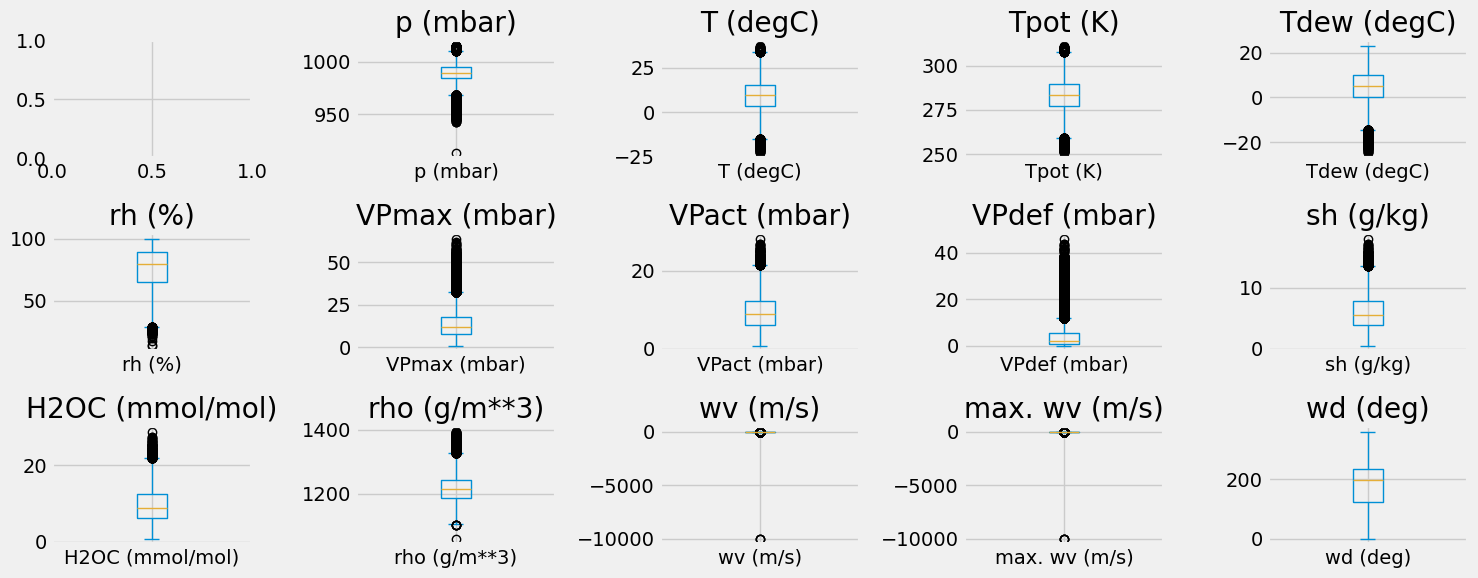

In [77]:
# Create a figure and axes for the boxplots
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 6))
axes = axes.flatten()

# Iterate over each column and plot the boxplot
for i, column in enumerate(df.columns):
    if column != 'Date Time': # We don't want to plot the datetime column
        df[column].plot.box(ax=axes[i])
        axes[i].set_title(column)

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()

Skipping column 'Date Time' as it contains non-numeric data.


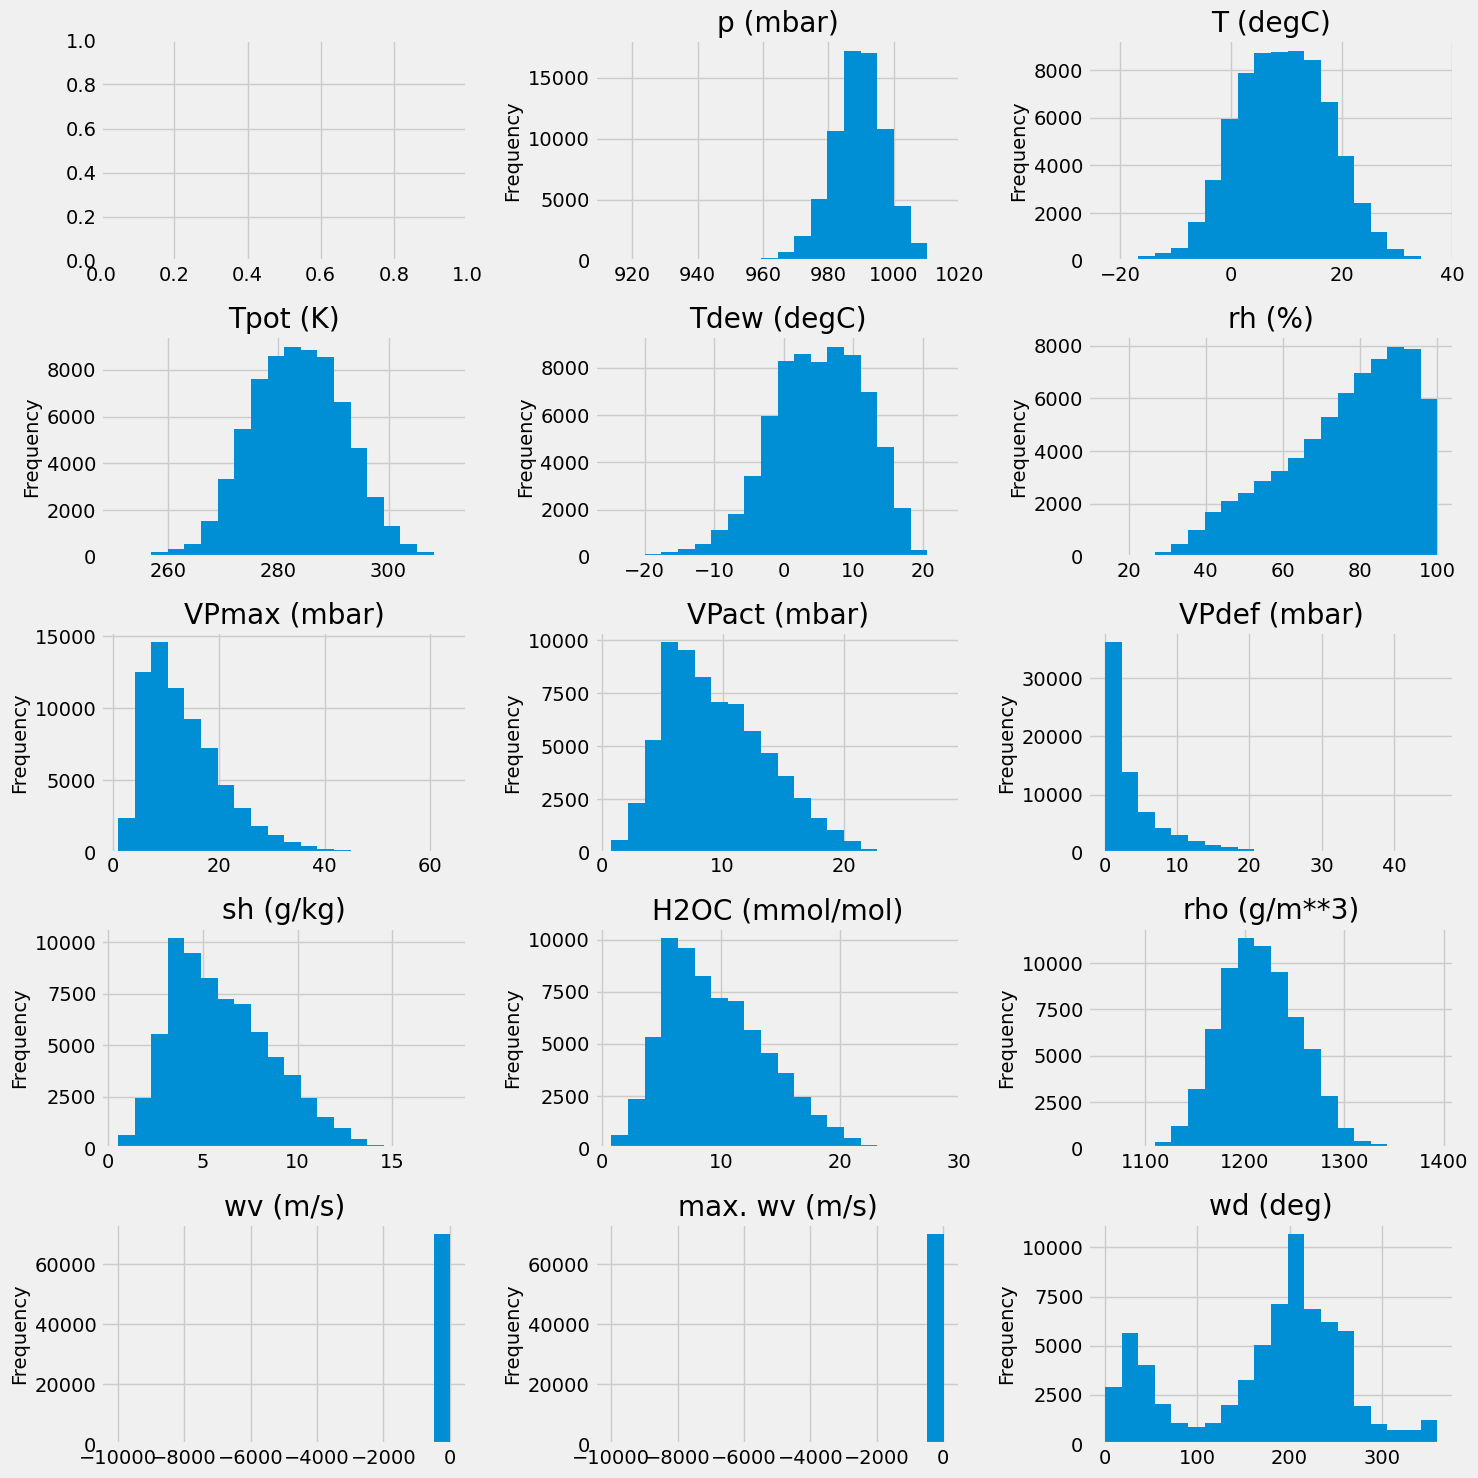

In [76]:
# Create a figure and axes for the histograms
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))
axes = axes.flatten()

# Iterate over each column and plot the histogram
for i, column in enumerate(df.columns):
    if column != 'Date Time': # We don't want to plot the datetime column

        df[column].plot.hist(ax=axes[i], bins=20)
        axes[i].set_title(column)
    else:
        print(f"Skipping column '{column}' as it contains non-numeric data.")

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()

Lets plot this to visualize what we are working with.

<Axes: title={'center': 'Temperature Time Series'}, xlabel='Date'>

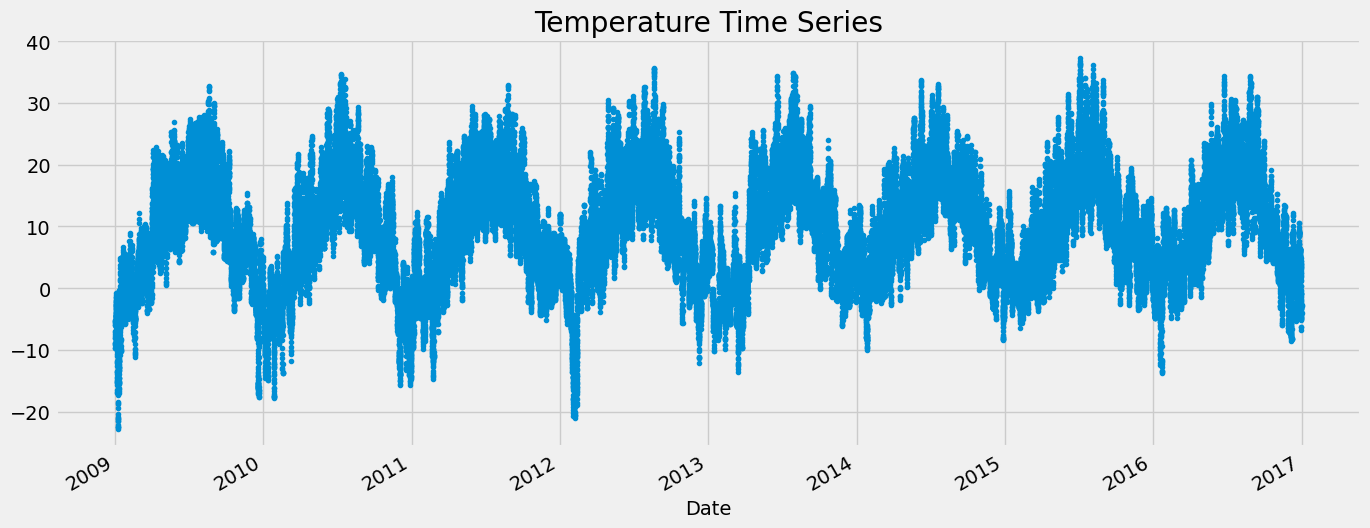

In [79]:
df['T (degC)'].plot(style='.',
        figsize=(15, 6),
        color=color_pal[0], 
        xlabel = "Date",
        title="Temperature Time Series")

<Axes: xlabel='Date Time'>

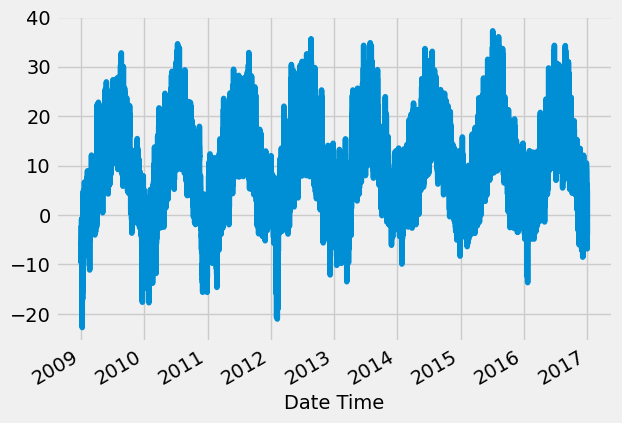

In [80]:
temp = df['T (degC)']
temp.plot()

And again, we clearly see the recurrent pattern. So we know that there is going to be fluctuations within a day, but also we see per year.

## Create model Function

In [83]:
def df_to_X_y(df, window_size=5):
    """Convert a Pandas dataframe to X,y numpy arrays that can be used by scikit-learn models"""
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)


In [84]:
WINDOW_SIZE = 5
X, y = df_to_X_y(temp, window_size=WINDOW_SIZE)
X.shape, y.shape

((70086, 5, 1), (70086,))

In [86]:
X


(array([[[-8.05],
         [-8.88],
         [-8.81],
         [-9.05],
         [-9.63]],
 
        [[-8.88],
         [-8.81],
         [-9.05],
         [-9.63],
         [-9.67]],
 
        [[-8.81],
         [-9.05],
         [-9.63],
         [-9.67],
         [-9.17]],
 
        ...,
 
        [[ 2.44],
         [ 1.29],
         [-0.42],
         [-0.98],
         [-1.4 ]],
 
        [[ 1.29],
         [-0.42],
         [-0.98],
         [-1.4 ],
         [-2.75]],
 
        [[-0.42],
         [-0.98],
         [-1.4 ],
         [-2.75],
         [-2.89]]]),
 array([-9.67, -9.17, -8.1 , ..., -2.75, -2.89, -3.93]))

Now we are ready to split data into train, test, and validation sets

## Train/Validate/Test Splits

We are going to split the data into training, validation, and testing sets.  We will use the first 60k rows for testing. 60k to 65k for validation, and the rest for testing.        

In [88]:
X_train, y_train = X[:60000], y[:60000]
X_val, y_val = X[60000:65000], y[60000:65000]
X_test, y_test = X[65000:], y[65000:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape  

((60000, 5, 1), (60000,), (5000, 5, 1), (5000,), (5086, 5, 1), (5086,))

In [95]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, InputLayer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [97]:
cp = ModelCheckpoint('model1/', save_best_only=True, monitor='val_loss', mode='min')
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

Fit the model

In [98]:
model1.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[cp])

Epoch 1/10
1871/1875 [============================>.] - ETA: 0s - loss: 27.6285 - root_mean_squared_error: 5.2563

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1875/1875 [==============================] - 38s 19ms/step - loss: 27.5763 - root_mean_squared_error: 5.2513 - val_loss: 1.4307 - val_root_mean_squared_error: 1.1961
Epoch 2/10
1871/1875 [============================>.] - ETA: 0s - loss: 2.1247 - root_mean_squared_error: 1.4576

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1875/1875 [==============================] - 27s 15ms/step - loss: 2.1223 - root_mean_squared_error: 1.4568 - val_loss: 0.6297 - val_root_mean_squared_error: 0.7935
Epoch 3/10
1870/1875 [============================>.] - ETA: 0s - loss: 0.9283 - root_mean_squared_error: 0.9635

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1875/1875 [==============================] - 27s 14ms/step - loss: 0.9271 - root_mean_squared_error: 0.9629 - val_loss: 0.5370 - val_root_mean_squared_error: 0.7328
Epoch 4/10
1873/1875 [============================>.] - ETA: 0s - loss: 0.7328 - root_mean_squared_error: 0.8560

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1875/1875 [==============================] - 27s 14ms/step - loss: 0.7334 - root_mean_squared_error: 0.8564 - val_loss: 0.5143 - val_root_mean_squared_error: 0.7171
Epoch 5/10
1871/1875 [============================>.] - ETA: 0s - loss: 0.6825 - root_mean_squared_error: 0.8262

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1875/1875 [==============================] - 26s 14ms/step - loss: 0.6828 - root_mean_squared_error: 0.8263 - val_loss: 0.5004 - val_root_mean_squared_error: 0.7074
Epoch 6/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.6658 - root_mean_squared_error: 0.8159

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1875/1875 [==============================] - 27s 14ms/step - loss: 0.6656 - root_mean_squared_error: 0.8159 - val_loss: 0.4952 - val_root_mean_squared_error: 0.7037
Epoch 7/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.6584 - root_mean_squared_error: 0.8114 - val_loss: 0.4975 - val_root_mean_squared_error: 0.7054
Epoch 8/10
1875/1875 [==============================] - 14s 8ms/step - loss: 0.6536 - root_mean_squared_error: 0.8085 - val_loss: 0.4968 - val_root_mean_squared_error: 0.7048
Epoch 9/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.6495 - root_mean_squared_error: 0.8059 - val_loss: 0.4990 - val_root_mean_squared_error: 0.7064
Epoch 10/10
1875/1875 [==============================] - ETA: 0s - loss: 0.6467 - root_mean_squared_error: 0.8042

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1875/1875 [==============================] - 27s 14ms/step - loss: 0.6467 - root_mean_squared_error: 0.8042 - val_loss: 0.4914 - val_root_mean_squared_error: 0.7010


Load the best model saved

In [99]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

Next, we will make a pandas dataframe for train, test, and validation showing where all the predictions are compared to the labels

In [101]:
train_preds = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions': train_preds, 'Actual Values': y_train})
train_results

   1/1875 [..............................] - ETA: 56s

1875/1875 [==============================] - 7s 4ms/step


,Train Predictions,Actual Values
0,-9.946155,-9.67
1,-9.674660,-9.17
2,-8.702243,-8.10
3,-7.171643,-7.66
4,-7.165312,-7.04
...,...,...
59995,5.919625,6.07
59996,7.204449,9.88
59997,12.197145,13.53
59998,15.851855,15.43


Plotting the predictions vs actuals on the training data

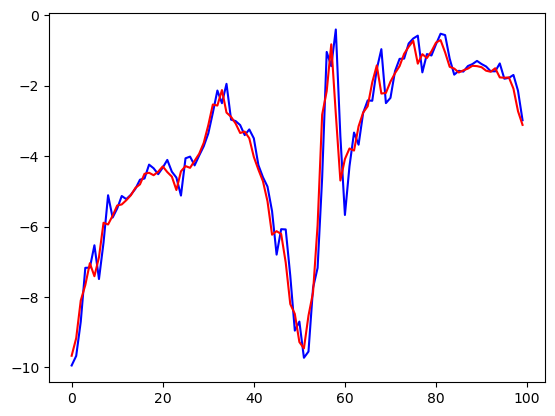

In [128]:
plt.plot(train_results['Train Predictions'][:100], 'b')
plt.plot(train_results['Actual Values'][:100], 'r')



The predictions follow the actuals very well. next, we will see how the model performs on the validation set

Validation

In [120]:
val_preds = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions': val_preds, 'Actual Values': y_val})
val_results

157/157 [==============================] - 1s 3ms/step


,Val Predictions,Actual Values
0,15.460074,14.02
1,13.300389,13.67
2,13.190604,12.27
3,11.614985,11.19
4,10.476735,10.85
...,...,...
4995,17.441708,18.27
4996,17.550123,17.85
4997,17.394260,16.65
4998,16.033150,15.85


Plot the validation predictions vs actuals

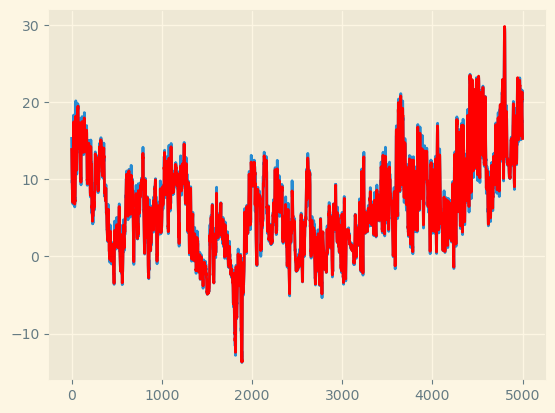

In [134]:
plt.plot(val_results['Val Predictions'])
plt.plot(val_results['Actual Values'], 'r')

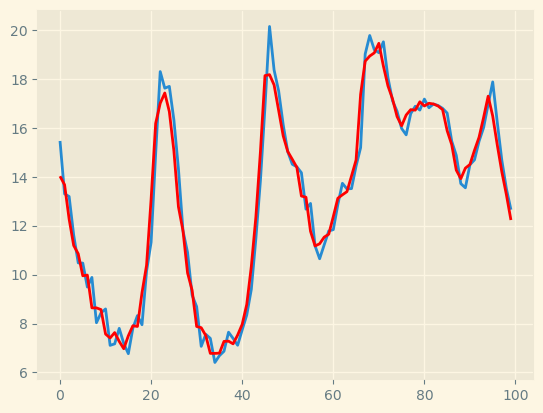

In [133]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actual Values'][:100], 'r')

Test results

In [135]:
test_preds = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions': test_preds, 'Actual Values': y_test})
test_results

159/159 [==============================] - 1s 3ms/step


,Test Predictions,Actual Values
0,14.565826,13.99
1,13.392699,13.46
2,12.999502,12.93
3,12.584978,12.43
4,12.121846,12.17
...,...,...
5081,-0.827189,-0.98
5082,-1.389772,-1.40
5083,-1.742353,-2.75
5084,-3.097837,-2.89


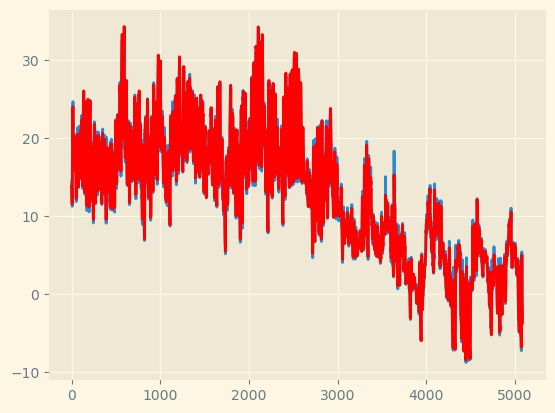

In [136]:
plt.plot(test_results['Test Predictions'])
plt.plot(test_results['Actual Values'], 'r')

## Step 3. Feature Engineering


We can use pandas .hour attribute to get the hour of the day for each index. We can also use other attributes to pull additional data from the index.  To make this cleaner, will create a function called features for our engineering.
   
We will add these as new columns to our dataframe.


In [13]:

def create_features(df):
    """
    Creates time series features from datetime index
    """
    df = df.copy() # We don't want to modify the original dataframe
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek # Monday=0, Sunday=6
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_features(df)

In [14]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365


## Visualizing the Feature / Target Relationship

Text(0.5, 1.0, 'Hourly Boxplot of Energy Consumption (in MWh)')

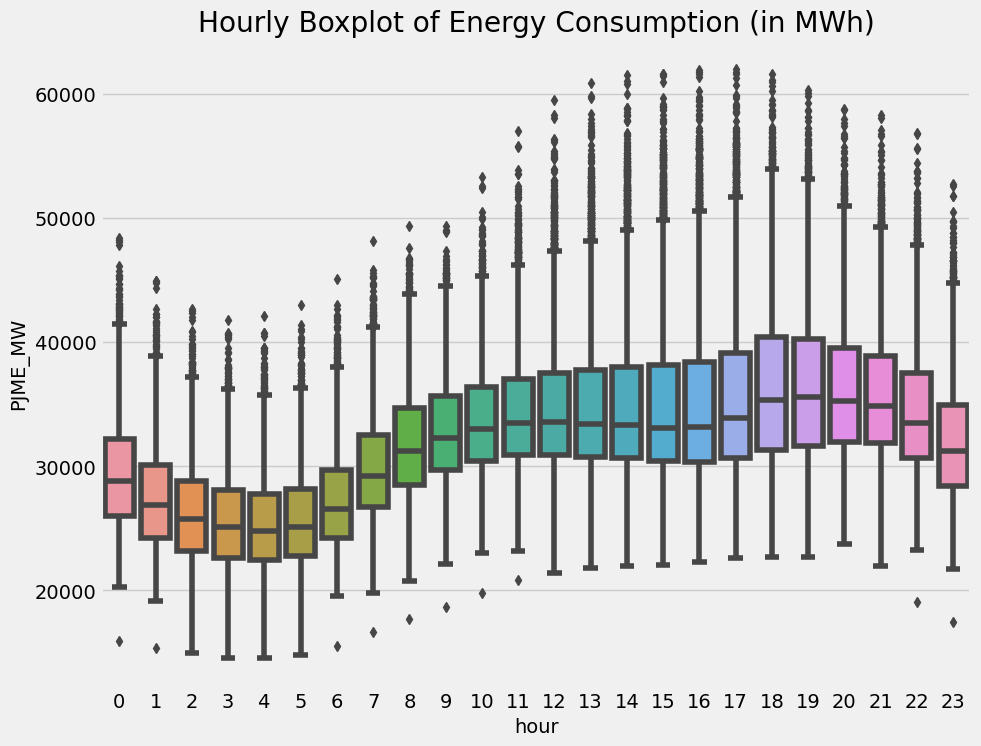

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(df, x='hour', y='PJME_MW')
ax.set_title('Hourly Boxplot of Energy Consumption (in MWh)')    # This is a style of plot

We see that early in the morning, there appears to be a dip in energy usage until 5.  It tends to get higher in the evening.

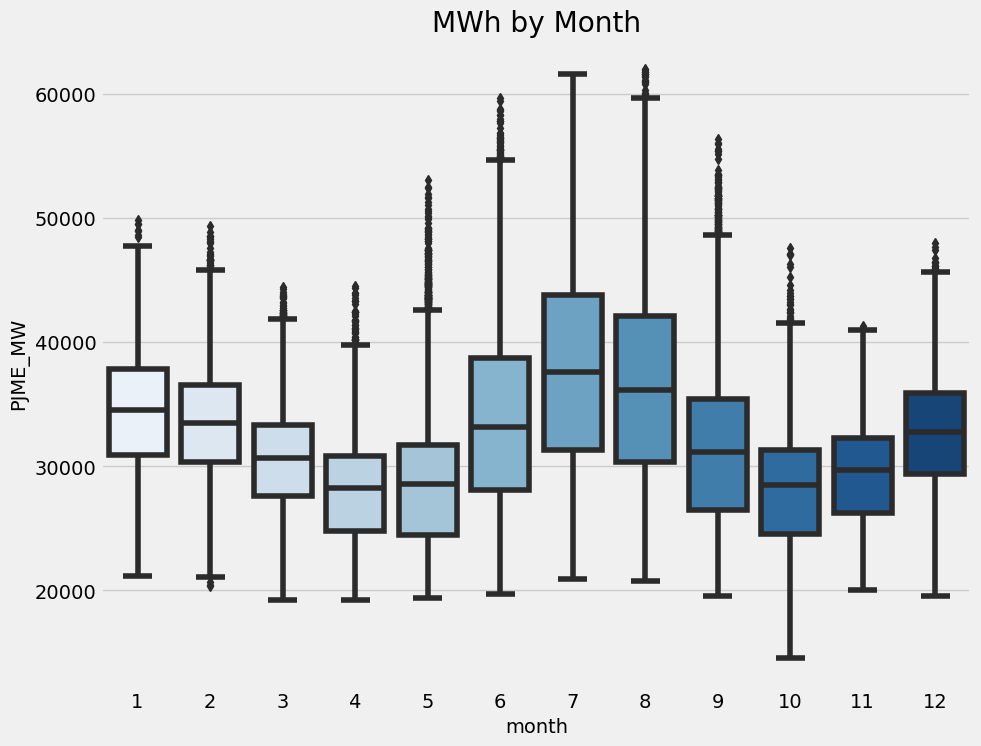

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MWh by Month') 
plt.show()

The MW usage by month tends to peak two times, in the winter season and again in the Summer

## Model Creation
  
  This model will be created on the training data and evaluated on the test data set.

In [17]:
# We need to run the training and testing data through the same features function
train = create_features(train)
test = create_features(test)

In [18]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear'],
      dtype='object')

In [19]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'PJME_MW'

In [20]:
# we need to drop the target values from the training and testing datasets
# X_train = train.drop('PJME_MW', axis=1) # axis=1 means we are dropping a column instead of a row
# y_train = train['PJME_MW']

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]  



In [21]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50,
                       learning_rate=0.01) 
reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        #early_stopping_rounds=50, # Activates early stopping. The model will train until the validation score stops improving.
        verbose=100) # If 'verbose' and an evaluation set is used, writes the evaluation metric measured on the validation set to stderr.

[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935


[100]	validation_0-rmse:12342.17856	validation_1-rmse:11516.21767
[200]	validation_0-rmse:5373.20460	validation_1-rmse:5164.97392
[300]	validation_0-rmse:3375.48321	validation_1-rmse:3834.00707
[400]	validation_0-rmse:2884.85132	validation_1-rmse:3716.33146
[451]	validation_0-rmse:2771.05175	validation_1-rmse:3731.37067


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

The output shows that RMSE goes down through each iteration on the training set. However, the validation on the test set starts to go down but then begins to get worse after 10 iterations.
  
  This is indicative of overfitting with n_estimators=1000.  Another thing we can do is lower the learning rate.

With a learning rate of 0.01, and verbose set to show every 100 trees built.  This stopped at 450 trees because our test or validation set started to get worse after that many trees were built.

## Feature Importance
This will give us the importance values based on how much these features were used in each of the trees built by the XGBoost model.



In [22]:
# This is a list of the importance of each feature 
fi = pd.DataFrame(data=reg.feature_importances_,
             index= reg.feature_names_in_,
             columns=['importance'])


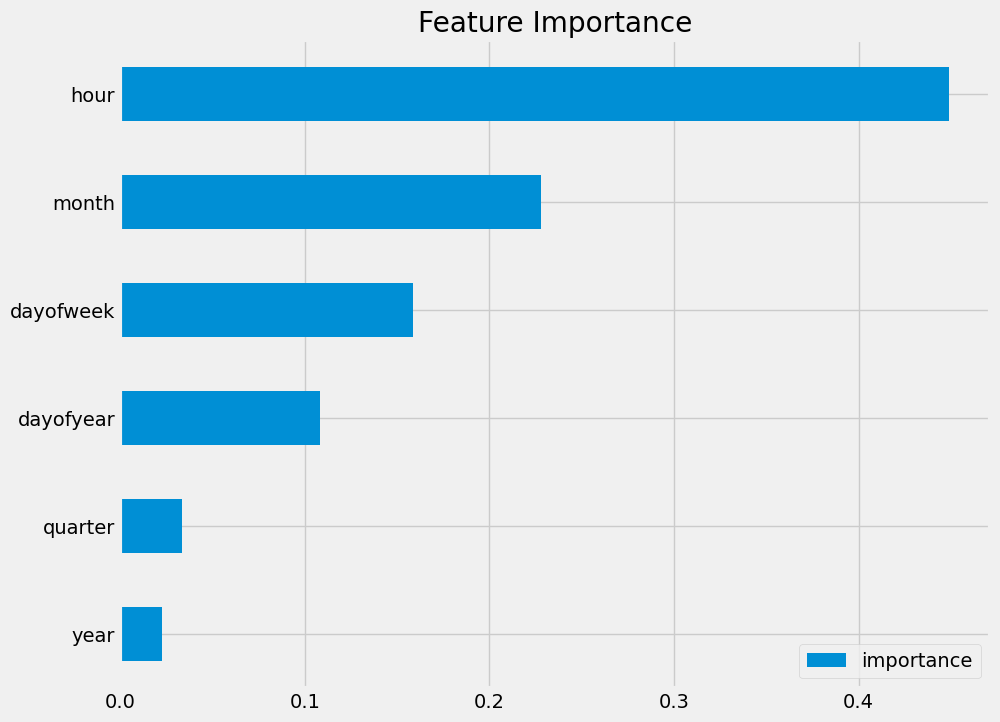

In [23]:
fi.sort_values(by='importance', ascending=True).plot(kind='barh', 
                                                      title='Feature Importance',
                                                      figsize=(10, 8)) 
plt.show()

Keep in mind that when you have highly correlated features, this feature importance functionality will not tell you exactly how important each feature is individually.

##  Forecast on Test


In [24]:
test['prediction'] = reg.predict(X_test)

Now I would like to see these predictions next to all the training data, so we will merge this.

In [25]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

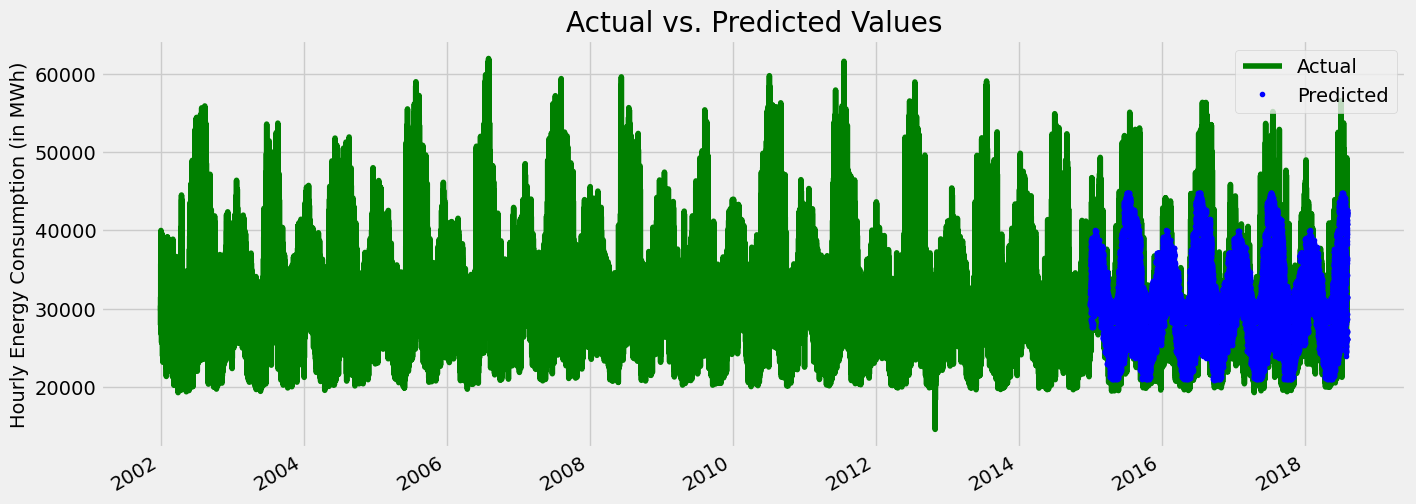

In [26]:
ax = df[['PJME_MW']].plot(figsize=(15, 6), color='green')
df['prediction'].plot(ax=ax, style='.', color = 'blue')
ax.set_title('Actual vs. Predicted Values')
ax.legend(['Actual', 'Predicted'])
ax.set_ylabel('Hourly Energy Consumption (in MWh)')
ax.set_xlabel('')
plt.show()


Similar to what was done previously, lets look at one week of data to see how the model performed.

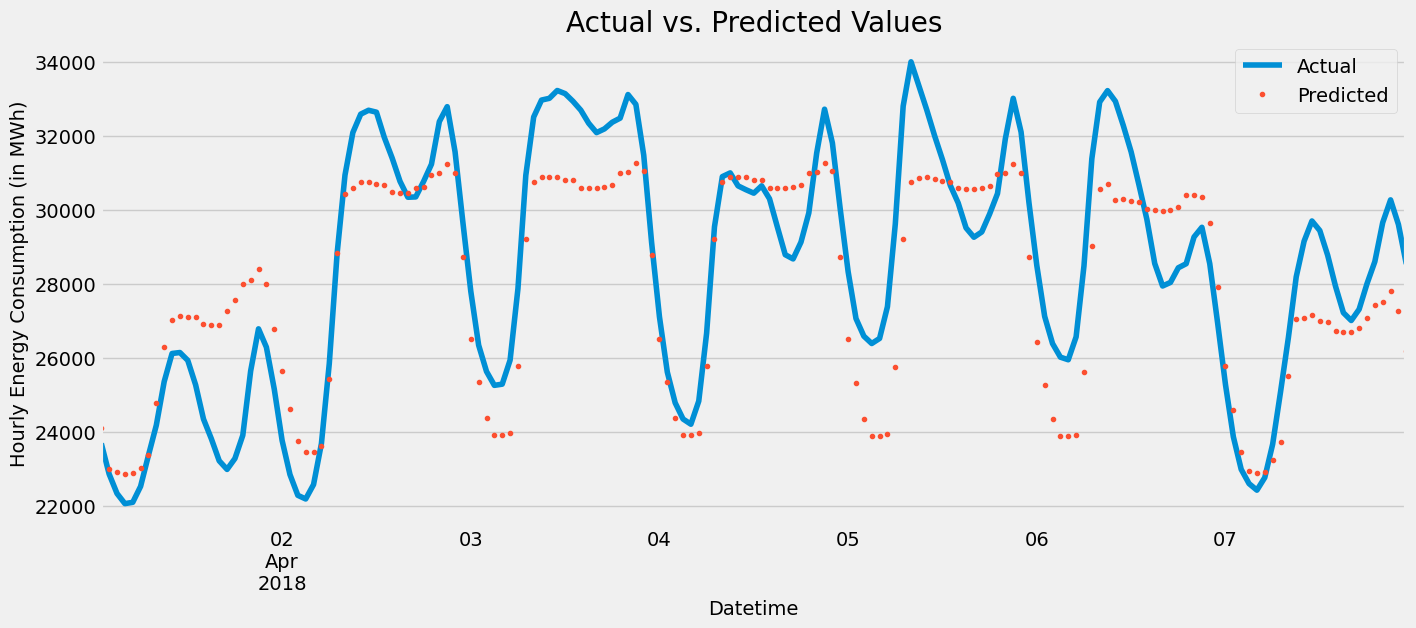

In [27]:

ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 6), title='A Week of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
ax.set_title('Actual vs. Predicted Values')
ax.legend(['Actual', 'Predicted'])
ax.set_ylabel('Hourly Energy Consumption (in MWh)')
plt.show()

We can see that the model isnt perfect. There is room for improvement. For example, this could include better parameter tuning.  Also, we could add in features for specific days of the year, like holidays.
    
The predictions do generally follow the trend you would expect to see with the peaks and valleys.

Lastly, we will run the evaluation metric on this

In [28]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction'])) # RMSE
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3715.93


### Calculate Error
* Look at the worst and best predicted days

In [29]:
test['error'] = np.abs(test[TARGET] -test['prediction'])

In [30]:
test['date'] = test.index.date

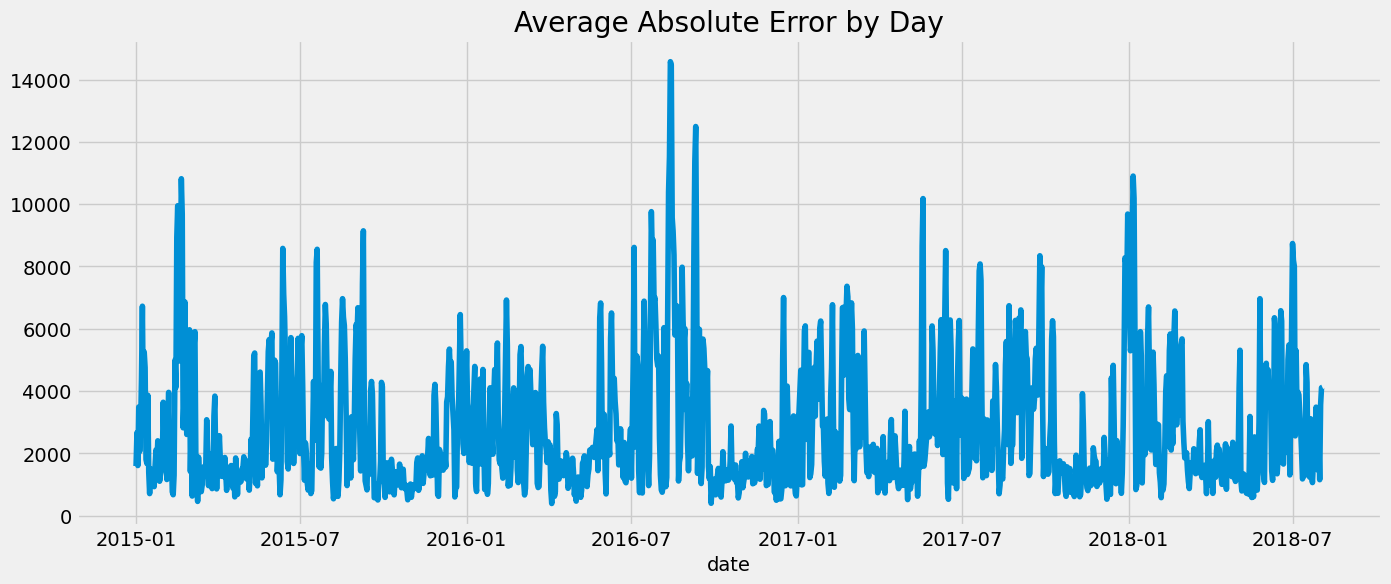

In [31]:
test.groupby('date')['error'].mean().plot(figsize=(15, 6),  
                                            title='Average Absolute Error by Day')
plt.show()

In [32]:
test.groupby('date')['error'].mean().sort_values().head(5)

date
2016-04-04    389.607829
2016-09-27    396.752116
2015-03-10    456.506510
2016-05-01    465.372640
2016-12-08    494.141764
Name: error, dtype: float64

Some of the best predictions were on days with the lowest average absolute error. These seem to be in 2016. 
  
  Next, Let's take a look at the worst days.

In [33]:
test.groupby('date')['error'].mean().sort_values(ascending=False).head(5)

date
2016-08-13    14577.210124
2016-08-14    14472.472738
2016-09-10    12494.880941
2016-08-12    11525.418376
2016-09-09    11369.640299
Name: error, dtype: float64

The worst predicted days all seem to be in the middle of August in 2016

### Next Steps:
- More robust cross-validation
- Add more features (i.e. Weather forecasts, holidays)

# The End